In [1]:
#0 Importação de bibliotecas essenciais
import os
import random
import numpy as np
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Configurações iniciais
SEED = 1234

def set_seeds(seed=1234):
    """Configurações para reprodutibilidade."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # Para multi-GPU

# Garantir reprodutibilidade
set_seeds(SEED)

# Definir dispositivo (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo configurado: {device}")


Dispositivo configurado: cuda


In [3]:
!pip install torchmetrics

In [4]:
#1 Definir os caminhos para os datasets
path_abnormal = "/home/thalles.fontainha/dataset/OAI-MRI-3DDESS/abnormal-3DESS-128-64.npy"
path_normal = "/home/thalles.fontainha/dataset/OAI-MRI-3DDESS/normal-3DESS-128-64.npy"

# Verificar se os arquivos existem
if not os.path.exists(path_abnormal):
    raise FileNotFoundError(f"Arquivo nao encontrado: {path_abnormal}")
if not os.path.exists(path_normal):
    raise FileNotFoundError(f"Arquivo nao encontrado: {path_normal}")

# Carregar os dados em arrays numpy
data_abnormal = np.load(path_abnormal)
data_normal = np.load(path_normal)

# Exibir informacoes basicas sobre os dados
print(f"Dados abnormal: shape={data_abnormal.shape}, tipo={data_abnormal.dtype}")
print(f"Dados normal: shape={data_normal.shape}, tipo={data_normal.dtype}")

# Exibir o numero total de entradas em cada conjunto
def count_images(data, label):
    print(f"Total {label} imagens: {len(data)}")

print("-------------------Dataset------------------")
count_images(data_abnormal, "abnormal")
count_images(data_normal, "normal")


Dados abnormal: shape=(1317, 128, 128, 64), tipo=float32
Dados normal: shape=(1659, 128, 128, 64), tipo=float32
-------------------Dataset------------------
Total abnormal imagens: 1317
Total normal imagens: 1659


In [7]:
#2 Dividir os datasets em treino, validacao e teste
# Proporcao 70:15:15
def split_dataset_with_labels(data_abnormal, data_normal, train_ratio=0.7, val_ratio=0.15):
    """
    Divide os dados abnormal e normal em conjuntos de treino, validação e teste.
    Adiciona rótulos (1 para abnormal, 0 para normal) diretamente durante a divisão.
    """
    # Determinar tamanhos de cada conjunto
    train_size_abnormal = int(len(data_abnormal) * train_ratio)
    val_size_abnormal = int(len(data_abnormal) * val_ratio)
    test_size_abnormal = len(data_abnormal) - (train_size_abnormal + val_size_abnormal)

    train_size_normal = int(len(data_normal) * train_ratio)
    val_size_normal = int(len(data_normal) * val_ratio)
    test_size_normal = len(data_normal) - (train_size_normal + val_size_normal)

    # Dividir os dados e adicionar rótulos diretamente
    train_data = [(x, 1) for x in data_abnormal[:train_size_abnormal]] + [(x, 0) for x in data_normal[:train_size_normal]]
    val_data = [(x, 1) for x in data_abnormal[train_size_abnormal:train_size_abnormal + val_size_abnormal]] + [(x, 0) for x in data_normal[train_size_normal:train_size_normal + val_size_normal]]
    test_data = [(x, 1) for x in data_abnormal[train_size_abnormal + val_size_abnormal:]] + [(x, 0) for x in data_normal[train_size_normal + val_size_normal:]]

    # Embaralhar para evitar padrões
    random.shuffle(train_data)
    random.shuffle(val_data)
    random.shuffle(test_data)

    return train_data, val_data, test_data

# Usar a função ajustada
train_data, val_data, test_data = split_dataset_with_labels(data_abnormal, data_normal)

# Validar tamanhos dos conjuntos
print("-------------------Dataset------------------")
print(f"Total de imagens no treino: {len(train_data)}")
print(f"Total de imagens na validação: {len(val_data)}")
print(f"Total de imagens no teste: {len(test_data)}")

# Verificar presença das classes no conjunto de teste
labels_test = [label for _, label in test_data]
print(f"Número de exemplos classe 0 (normal): {labels_test.count(0)}")
print(f"Número de exemplos classe 1 (abnormal): {labels_test.count(1)}")


-------------------Dataset------------------
Total de imagens no treino: 2082
Total de imagens na validação: 445
Total de imagens no teste: 449
Número de exemplos classe 0 (normal): 250
Número de exemplos classe 1 (abnormal): 199


In [10]:
#3 Analisar os shapes dos dados carregados
def analyze_data_shapes(data_abnormal, data_normal):
    """
    Exibe os shapes dos dados abnormal e normal para inspeção.
    """
    print(f"Shape de data_abnormal: {data_abnormal.shape}")
    print(f"Shape de data_normal: {data_normal.shape}")
    print(f"Total de imagens abnormal: {len(data_abnormal)}")
    print(f"Total de imagens normal: {len(data_normal)}")

# Aplicar a análise
analyze_data_shapes(data_abnormal, data_normal)



Shape de data_abnormal: (1317, 128, 128, 64)
Shape de data_normal: (1659, 128, 128, 64)
Total de imagens abnormal: 1317
Total de imagens normal: 1659


In [11]:
#4 Verificar distribuição de classes no conjunto de teste
def analyze_class_distribution(test_data):
    """
    Analisa e exibe a distribuição de classes no conjunto de teste.
    """
    labels_test = [label for _, label in test_data]  # Extrair rótulos
    num_normal = labels_test.count(0)
    num_abnormal = labels_test.count(1)

    print(f"Número de exemplos classe 0 (normal): {num_normal}")
    print(f"Número de exemplos classe 1 (abnormal): {num_abnormal}")

# Aplicar a análise
analyze_class_distribution(test_data)



Número de exemplos classe 0 (normal): 250
Número de exemplos classe 1 (abnormal): 199


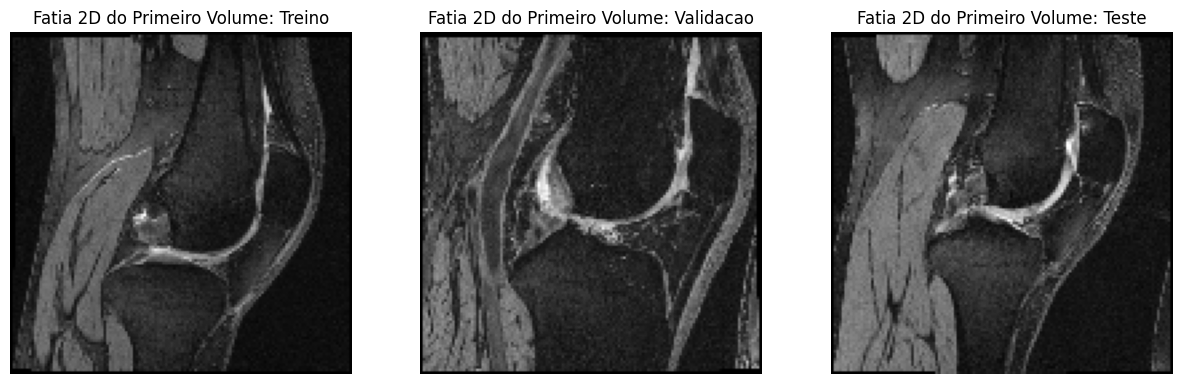

In [12]:
#5 Exibir tres imagens: uma de treino, uma de validacao, uma de teste
def visualize_images(train_data, val_data, test_data):
    """
    Visualiza uma fatia central de um volume de treino, validacao e teste.
    """
    # Selecionar uma fatia central de cada conjunto
    train_image = train_data[0][0][:, :, train_data[0][0].shape[2] // 2]  # Fatia central do primeiro volume
    val_image = val_data[0][0][:, :, val_data[0][0].shape[2] // 2]        # Fatia central do primeiro volume
    test_image = test_data[0][0][:, :, test_data[0][0].shape[2] // 2]     # Fatia central do primeiro volume

    # Normalizar os valores para 0-255
    def normalize_image(image):
        image = (image - image.min()) / (image.max() - image.min())  # Normalizar para [0, 1]
        return (image * 255).astype(np.uint8)  # Escalar para [0, 255]

    train_image = normalize_image(train_image)
    val_image = normalize_image(val_image)
    test_image = normalize_image(test_image)

    # Criar o plot
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(train_image, cmap='gray')
    plt.title('Fatia 2D do Primeiro Volume: Treino')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(val_image, cmap='gray')
    plt.title('Fatia 2D do Primeiro Volume: Validacao')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(test_image, cmap='gray')
    plt.title('Fatia 2D do Primeiro Volume: Teste')
    plt.axis('off')

    plt.show()

# Visualizar as imagens
visualize_images(train_data, val_data, test_data)


### Pré-processamento
Nesta etapa, define-se o pipeline de pre-processamento de dados para nosso conjunto de dados. Usando o modulo transforms da biblioteca PyTorch para executar uma série de transformações de imagem no conjunto de dados.

As imagens são pré-processadas por redimensionamento, rotação aleatória, inversão, corte central, conversão para tensores e normalização usando a média e o desvio padrão do conjunto de dados. Essas etapas são executadas para garantir que todas as imagens estejam no mesmo tamanho e formato, prontas para serem inseridas no modelo.

In [13]:
#6 Definir as transformacoes para os datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Dados em escala de cinza (1 canal)
    ]),
    'others': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Dados em escala de cinza (1 canal)
    ]),
}


In [14]:
#7 Definir a classe customizada para o dataset
class OAI_MRI_Dataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Inicializa o dataset com os dados e rótulos.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retorna uma imagem e seu rótulo correspondente.
        """
        # Obter volume e rótulo
        volume, label = self.data[idx]

        # Selecionar uma fatia central
        slice_index = volume.shape[2] // 2
        image_data = volume[:, :, slice_index]

        # Normalizar os valores
        image_data = (image_data - image_data.min()) / (image_data.max() - image_data.min())
        image_data = (image_data * 255).astype(np.uint8)

        # Converter para imagem PIL
        image = Image.fromarray(image_data)

        # Aplicar transformações (se houver)
        if self.transform:
            image = self.transform(image)

        return image, label

# Criar datasets para treino, validacao e teste
train_dataset = OAI_MRI_Dataset(train_data, transform=data_transforms['train'])
val_dataset = OAI_MRI_Dataset(val_data, transform=data_transforms['others'])
test_dataset = OAI_MRI_Dataset(test_data, transform=data_transforms['others'])

# Criar DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


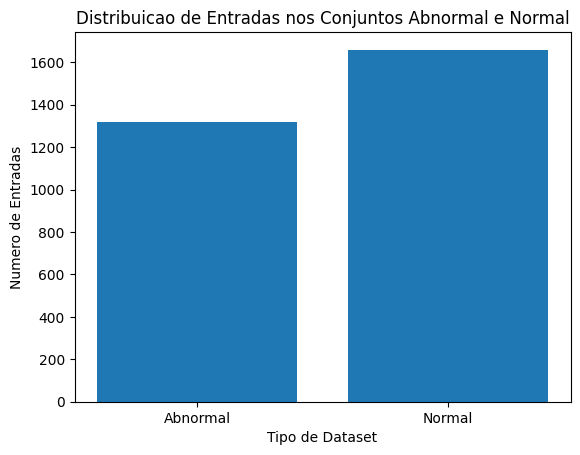

In [15]:
#8 Visualizar distribuicao de dados
abnormal_size = len(data_abnormal)
normal_size = len(data_normal)
sizes = [abnormal_size, normal_size]

plt.bar(['Abnormal', 'Normal'], sizes)
plt.xlabel('Tipo de Dataset')
plt.ylabel('Numero de Entradas')
plt.title('Distribuicao de Entradas nos Conjuntos Abnormal e Normal')
plt.show()


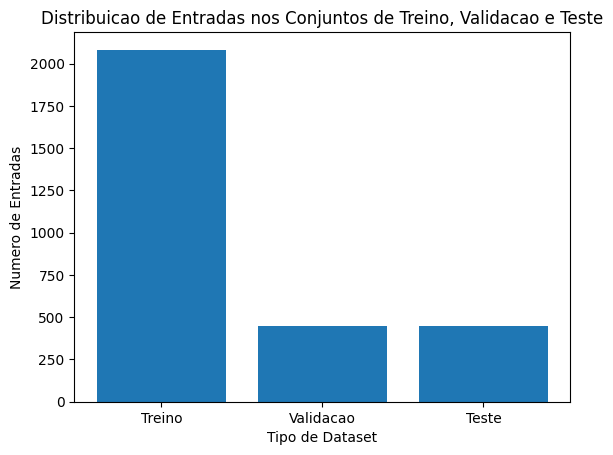

In [16]:
#9 Visualizar distribuicao dos datasets de treino, validacao e teste
train_size = len(train_data)
valid_size = len(val_data)
test_size = len(test_data)

# Criar lista com os tamanhos
sizes = [train_size, valid_size, test_size]

# Criar o grafico de barras
plt.bar(['Treino', 'Validacao', 'Teste'], sizes)
plt.xlabel('Tipo de Dataset')
plt.ylabel('Numero de Entradas')
plt.title('Distribuicao de Entradas nos Conjuntos de Treino, Validacao e Teste')
plt.show()


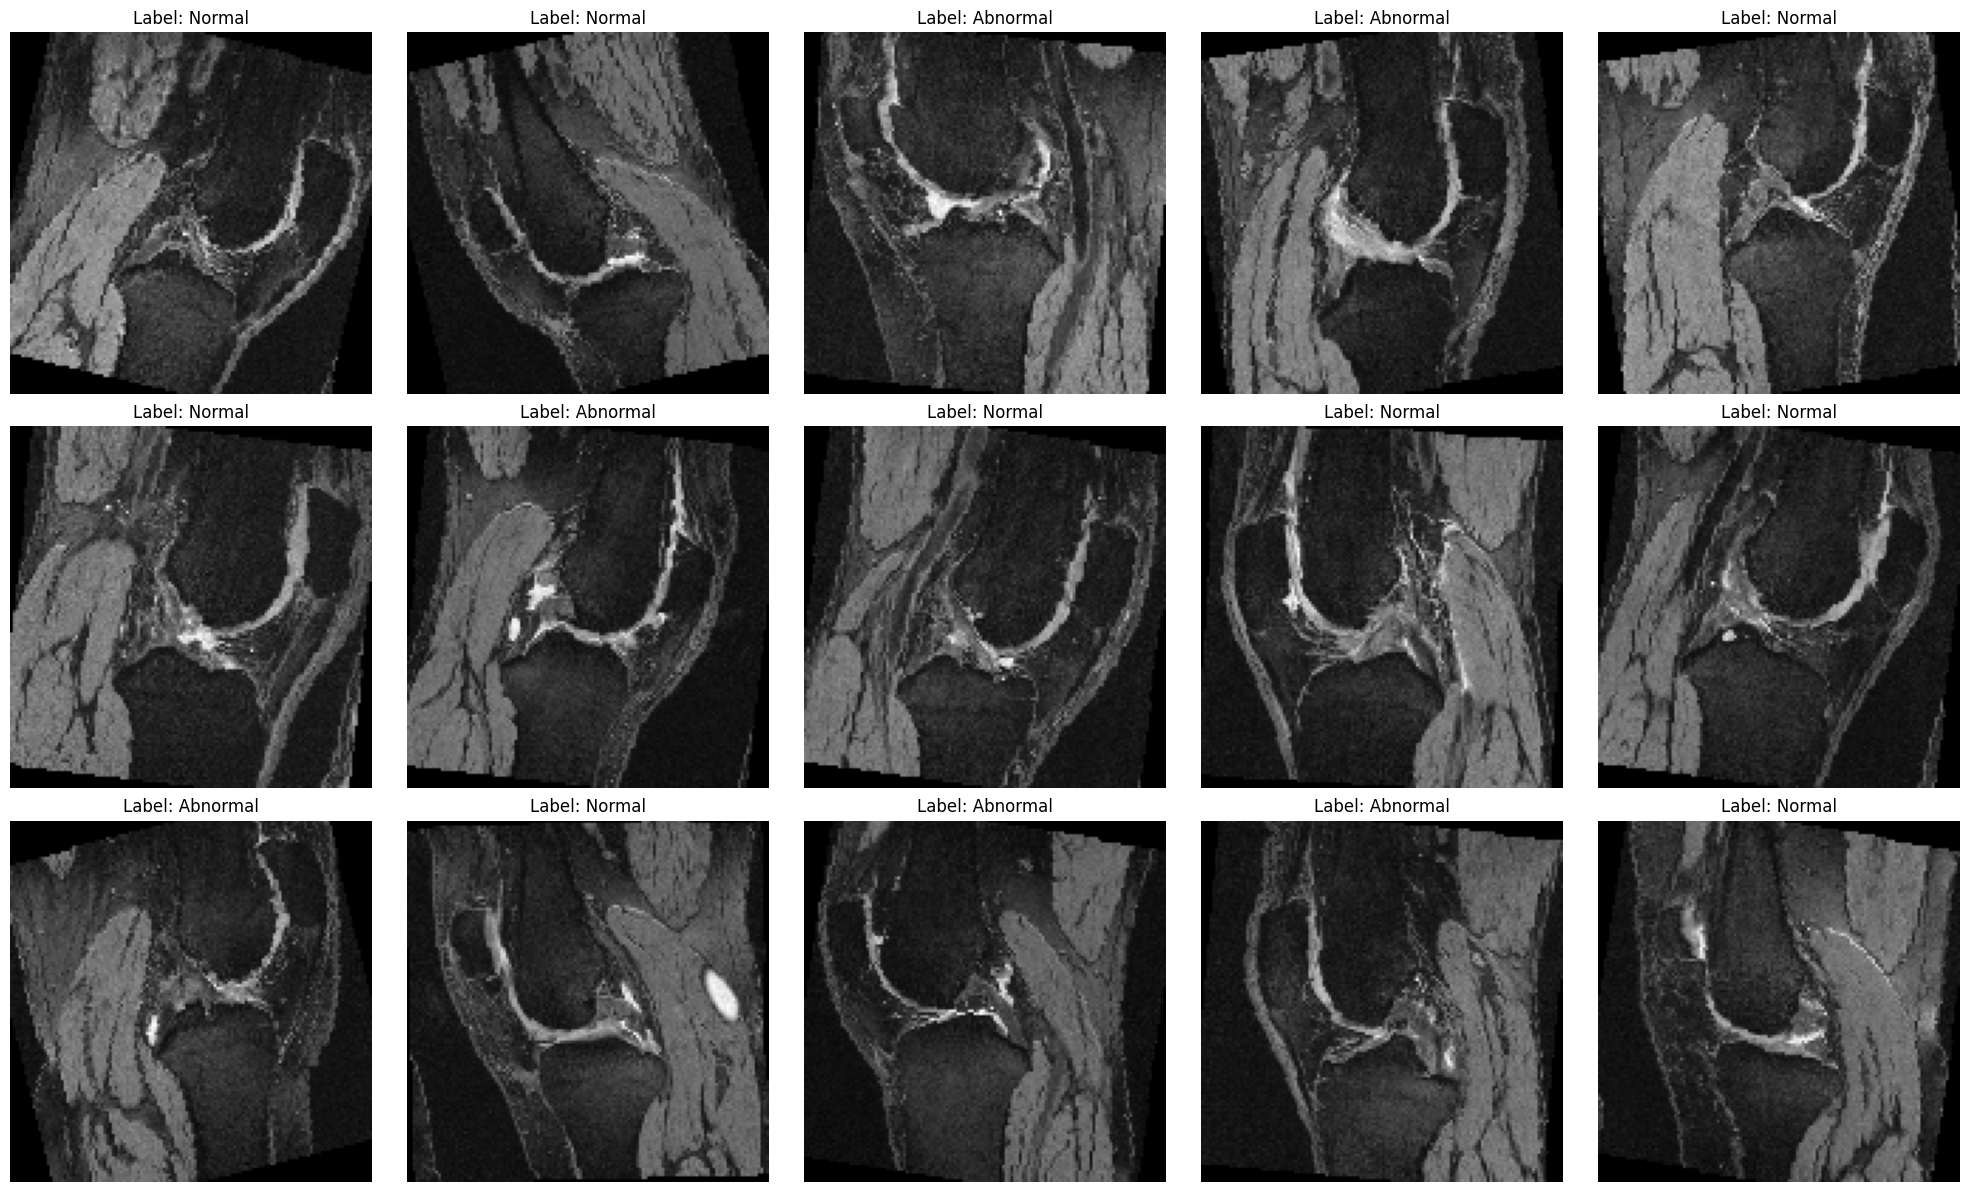

In [17]:
#10 Visualizar algumas imagens do DataLoader
# Carregar um batch de dados
data, labels = next(iter(train_dataloader))

# Criar figura com uma grade de subplots
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))

# Plotar as imagens nos subplots
for i, ax in enumerate(axs.flat):
    if i >= len(data):
        break

    # Obter a imagem e o label
    image, label = data[i], labels[i]

    # Converter a imagem para numpy array
    img = image.numpy().squeeze()  # Remove dimensões extras (para imagens cinza)
    img = (img - img.min()) / (img.max() - img.min())  # Normalizar para [0, 1]

    # Mostrar a imagem
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {"Abnormal" if label == 1 else "Normal"}')
    ax.axis('off')

# Mostrar o gráfico
plt.tight_layout()
plt.show()


In [19]:
from IPython.display import Markdown, display

# Texto explicativo
description = """
### Visualização de Imagens do Conjunto de Treino
A imagem acima exibe fatias 2D de volumes de ressonância magnética extraídas do conjunto de treino. Cada subplot corresponde a:

- **Label: Normal**: Condições saudáveis (rótulo 0).
- **Label: Abnormal**: Presença de anormalidades (rótulo 1).

Essas imagens passaram por transformações como rotação aleatória e inversão horizontal, utilizadas para aumentar a robustez do modelo ao longo do treinamento.
"""

# Mostrar a descrição
display(Markdown(description))



### Visualização de Imagens do Conjunto de Treino
A imagem acima exibe fatias 2D de volumes de ressonância magnética extraídas do conjunto de treino. Cada subplot corresponde a:

- **Label: Normal**: Condições saudáveis (rótulo 0).
- **Label: Abnormal**: Presença de anormalidades (rótulo 1).

Essas imagens passaram por transformações como rotação aleatória e inversão horizontal, utilizadas para aumentar a robustez do modelo ao longo do treinamento.


In [18]:
#11 Definir o modelo baseado no DenseNet121
class OAI_DenseNetModel(nn.Module):
    """Modelo DenseNet121 pretreinado adaptado para OAI."""
    def __init__(self, num_classes):
        super(OAI_DenseNetModel, self).__init__()

        # Carregar o modelo DenseNet121 com pesos pretreinados
        self.model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

        # Congelar os parâmetros do modelo base
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Substituir a camada classificador
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, in_features // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features // 2, in_features // 4),
            nn.ReLU(),
            nn.Linear(in_features // 4, num_classes),
        )

    def forward(self, x):
        return self.model(x)

# Instanciar o modelo
model = OAI_DenseNetModel(num_classes=2)

# Definir dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Mostrar a arquitetura do modelo
print(model)



OAI_DenseNetModel(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [20]:
#12 Calcular os pesos para cada classe no conjunto de treino

# Contar os exemplos de cada classe no conjunto de treino
def calculate_class_distribution(dataloader):
    """Calcula a distribuição das classes em um DataLoader."""
    abnormal_count = 0
    normal_count = 0
    for _, labels in dataloader:
        abnormal_count += torch.sum(labels == 1).item()  # Classe Abnormal (rótulo 1)
        normal_count += torch.sum(labels == 0).item()    # Classe Normal (rótulo 0)
    return abnormal_count, normal_count

# Obter a contagem das classes no conjunto de treino
abnormal_count, normal_count = calculate_class_distribution(train_dataloader)

# Calcular o total de exemplos
total = abnormal_count + normal_count

# Função para calcular pesos
def class_weight(count, total):
    return 1 - (count / total)

# Calcular os pesos para cada classe
class_weights = torch.tensor([
    class_weight(normal_count, total),  # Peso para a classe Normal (rótulo 0)
    class_weight(abnormal_count, total)  # Peso para a classe Abnormal (rótulo 1)
], dtype=torch.float32).to(device)  # Passar os pesos para o mesmo dispositivo do modelo

# Exibir os pesos calculados
print(f"Pesos das classes calculados:")
print(f"Classe Normal (0): {class_weights[0]:.4f}")
print(f"Classe Abnormal (1): {class_weights[1]:.4f}")


Pesos das classes calculados:
Classe Normal (0): 0.4424
Classe Abnormal (1): 0.5576


In [21]:
#13 Definir a função de perda Binary CrossEntropy e o otimizador Adam

# Função de perda: BCEWithLogitsLoss com pesos para as classes
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Usar o peso da classe Abnormal

# Otimizador: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler: Decaimento do learning rate a cada 3 épocas
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Exibir as configurações
print(f"Função de perda: {loss_fn}")
print(f"Otimização: Adam com learning rate inicial 0.001")
print(f"Agendador de LR: StepLR com step_size=3, gamma=0.1")


Função de perda: BCEWithLogitsLoss()
Otimização: Adam com learning rate inicial 0.001
Agendador de LR: StepLR com step_size=3, gamma=0.1


In [22]:
#14 Criar DataLoaders para treino, validação e teste

# Configurar DataLoaders com DataLoader
batch_size = 32  # Tamanho do batch

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Exibir o número de batches em cada DataLoader
print(f"Total de batches no treino: {len(train_dataloader)}")
print(f"Total de batches na validação: {len(valid_dataloader)}")
print(f"Total de batches no teste: {len(test_dataloader)}")


Total de batches no treino: 66
Total de batches na validação: 14
Total de batches no teste: 15


In [23]:
#15 Definir a função de treinamento e validação
from tqdm import tqdm
import torch.nn.functional as F

# Listas para armazenar as perdas e acurácias ao longo das épocas
train_losses = []
valid_losses = []
train_acc = []
valid_acc = []

def train(model, loss_fn, optimizer, scheduler, num_epochs):
    """Função de treinamento e validação."""
    for epoch in tqdm(range(num_epochs), desc="Treinamento em andamento"):
        # Etapa de treinamento
        model.train()

        train_size = 0
        train_loss = 0.0
        train_accuracy = 0.0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)

            # Ajustar os canais das imagens para o esperado pelo DenseNet121
            if images.shape[1] == 1:  # Se for escala de cinza
                images = images.repeat(1, 3, 1, 1)  # Replicar o canal para RGB

            # Zerar os gradientes do otimizador
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, F.one_hot(labels, 2).float())

            # Calcular a acurácia do treino
            _, preds = torch.max(outputs, 1)
            train_accuracy += torch.sum(preds == labels.data)

            # Backward pass e otimização
            loss.backward()
            optimizer.step()

            # Acumular a perda e o tamanho do conjunto de treino
            train_loss += loss.item() * images.size(0)
            train_size += images.size(0)

        # Etapa de validação
        model.eval()

        valid_size = 0
        valid_loss = 0.0
        valid_accuracy = 0.0

        with torch.no_grad():
            for images, labels in valid_dataloader:
                images, labels = images.to(device), labels.to(device)

                # Ajustar os canais para o DenseNet121
                if images.shape[1] == 1:
                    images = images.repeat(1, 3, 1, 1)

                outputs = model(images)
                loss = loss_fn(outputs, F.one_hot(labels, 2).float())

                # Calcular a acurácia da validação
                _, preds = torch.max(outputs, 1)
                valid_accuracy += torch.sum(preds == labels.data)

                # Acumular a perda e o tamanho do conjunto de validação
                valid_loss += loss.item() * images.size(0)
                valid_size += images.size(0)

        # Atualizar estatísticas após cada época
        train_loss = train_loss / train_size
        train_losses.append(train_loss)
        train_accuracy = train_accuracy / train_size
        train_acc.append(train_accuracy)

        valid_loss = valid_loss / valid_size
        valid_losses.append(valid_loss)
        valid_accuracy = valid_accuracy / valid_size
        valid_acc.append(valid_accuracy)

        # Atualizar o scheduler (se necessário)
        scheduler.step()

        # Exibir resultados para a época
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}")
        print(f"Valid Loss: {valid_loss:.3f}, Valid Accuracy: {valid_accuracy:.3f}")

# Treinar o modelo
train(model, loss_fn, optimizer, scheduler, num_epochs=25)


Treinamento em andamento:   4%|▍         | 1/25 [00:06<02:24,  6.04s/it]


Epoch 1/25
Train Loss: 0.504, Train Accuracy: 0.557
Valid Loss: 0.486, Valid Accuracy: 0.600


Treinamento em andamento:   8%|▊         | 2/25 [00:11<02:05,  5.46s/it]


Epoch 2/25
Train Loss: 0.504, Train Accuracy: 0.558
Valid Loss: 0.490, Valid Accuracy: 0.580


Treinamento em andamento:  12%|█▏        | 3/25 [00:15<01:53,  5.17s/it]


Epoch 3/25
Train Loss: 0.491, Train Accuracy: 0.594
Valid Loss: 0.480, Valid Accuracy: 0.620


Treinamento em andamento:  16%|█▌        | 4/25 [00:20<01:47,  5.11s/it]


Epoch 4/25
Train Loss: 0.477, Train Accuracy: 0.626
Valid Loss: 0.479, Valid Accuracy: 0.613


Treinamento em andamento:  20%|██        | 5/25 [00:25<01:40,  5.02s/it]


Epoch 5/25
Train Loss: 0.471, Train Accuracy: 0.640
Valid Loss: 0.485, Valid Accuracy: 0.600


Treinamento em andamento:  24%|██▍       | 6/25 [00:30<01:34,  4.97s/it]


Epoch 6/25
Train Loss: 0.473, Train Accuracy: 0.625
Valid Loss: 0.478, Valid Accuracy: 0.611


Treinamento em andamento:  28%|██▊       | 7/25 [00:35<01:28,  4.94s/it]


Epoch 7/25
Train Loss: 0.476, Train Accuracy: 0.632
Valid Loss: 0.476, Valid Accuracy: 0.620


Treinamento em andamento:  32%|███▏      | 8/25 [00:40<01:22,  4.83s/it]


Epoch 8/25
Train Loss: 0.470, Train Accuracy: 0.642
Valid Loss: 0.478, Valid Accuracy: 0.609


Treinamento em andamento:  36%|███▌      | 9/25 [00:45<01:17,  4.87s/it]


Epoch 9/25
Train Loss: 0.474, Train Accuracy: 0.633
Valid Loss: 0.477, Valid Accuracy: 0.622


Treinamento em andamento:  40%|████      | 10/25 [00:49<01:12,  4.86s/it]


Epoch 10/25
Train Loss: 0.474, Train Accuracy: 0.631
Valid Loss: 0.478, Valid Accuracy: 0.631


Treinamento em andamento:  44%|████▍     | 11/25 [00:54<01:07,  4.84s/it]


Epoch 11/25
Train Loss: 0.468, Train Accuracy: 0.636
Valid Loss: 0.478, Valid Accuracy: 0.613


Treinamento em andamento:  48%|████▊     | 12/25 [00:59<01:03,  4.88s/it]


Epoch 12/25
Train Loss: 0.469, Train Accuracy: 0.638
Valid Loss: 0.477, Valid Accuracy: 0.622


Treinamento em andamento:  52%|█████▏    | 13/25 [01:04<00:58,  4.91s/it]


Epoch 13/25
Train Loss: 0.467, Train Accuracy: 0.648
Valid Loss: 0.480, Valid Accuracy: 0.620


Treinamento em andamento:  56%|█████▌    | 14/25 [01:09<00:54,  4.93s/it]


Epoch 14/25
Train Loss: 0.475, Train Accuracy: 0.634
Valid Loss: 0.476, Valid Accuracy: 0.611


Treinamento em andamento:  60%|██████    | 15/25 [01:14<00:49,  4.91s/it]


Epoch 15/25
Train Loss: 0.467, Train Accuracy: 0.651
Valid Loss: 0.477, Valid Accuracy: 0.631


Treinamento em andamento:  64%|██████▍   | 16/25 [01:19<00:44,  4.89s/it]


Epoch 16/25
Train Loss: 0.468, Train Accuracy: 0.644
Valid Loss: 0.476, Valid Accuracy: 0.618


Treinamento em andamento:  68%|██████▊   | 17/25 [01:24<00:39,  4.88s/it]


Epoch 17/25
Train Loss: 0.471, Train Accuracy: 0.625
Valid Loss: 0.479, Valid Accuracy: 0.613


Treinamento em andamento:  72%|███████▏  | 18/25 [01:29<00:34,  4.89s/it]


Epoch 18/25
Train Loss: 0.471, Train Accuracy: 0.645
Valid Loss: 0.481, Valid Accuracy: 0.602


Treinamento em andamento:  76%|███████▌  | 19/25 [01:33<00:29,  4.87s/it]


Epoch 19/25
Train Loss: 0.470, Train Accuracy: 0.634
Valid Loss: 0.477, Valid Accuracy: 0.631


Treinamento em andamento:  80%|████████  | 20/25 [01:38<00:24,  4.90s/it]


Epoch 20/25
Train Loss: 0.469, Train Accuracy: 0.636
Valid Loss: 0.477, Valid Accuracy: 0.604


Treinamento em andamento:  84%|████████▍ | 21/25 [01:43<00:19,  4.94s/it]


Epoch 21/25
Train Loss: 0.476, Train Accuracy: 0.631
Valid Loss: 0.479, Valid Accuracy: 0.616


Treinamento em andamento:  88%|████████▊ | 22/25 [01:48<00:14,  4.93s/it]


Epoch 22/25
Train Loss: 0.471, Train Accuracy: 0.637
Valid Loss: 0.481, Valid Accuracy: 0.611


Treinamento em andamento:  92%|█████████▏| 23/25 [01:53<00:09,  4.93s/it]


Epoch 23/25
Train Loss: 0.466, Train Accuracy: 0.643
Valid Loss: 0.474, Valid Accuracy: 0.622


Treinamento em andamento:  96%|█████████▌| 24/25 [01:58<00:04,  4.95s/it]


Epoch 24/25
Train Loss: 0.470, Train Accuracy: 0.630
Valid Loss: 0.478, Valid Accuracy: 0.627


Treinamento em andamento: 100%|██████████| 25/25 [02:03<00:00,  4.94s/it]


Epoch 25/25
Train Loss: 0.471, Train Accuracy: 0.636
Valid Loss: 0.480, Valid Accuracy: 0.618


## Avaliação

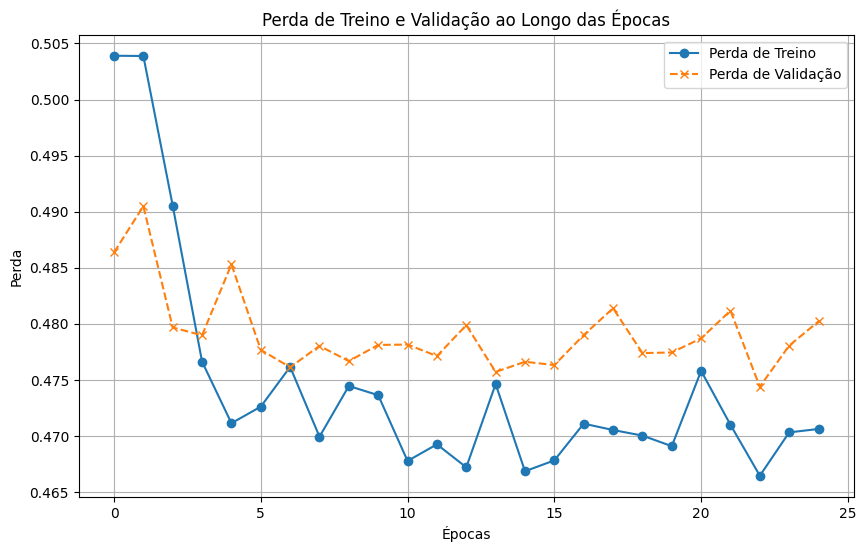

In [24]:
#16 Plotar as perdas de treino e validação
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotar as perdas de treino e validação
plt.plot(train_losses, label='Perda de Treino', linestyle='-', marker='o')
plt.plot(valid_losses, label='Perda de Validação', linestyle='--', marker='x')

# Configurações do gráfico
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.title('Perda de Treino e Validação ao Longo das Épocas')
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()


O gráfico do #16 mostra que a perda de treino diminui consistentemente ao longo das épocas, o que indica que o modelo está ajustando seus parâmetros para se adequar aos dados de treino. No entanto, a perda de validação apresenta um comportamento instável, com flutuações significativas, e não demonstra uma tendência clara de redução. Isso pode ser um sinal de overfitting, pois o modelo pode estar aprendendo padrões específicos do treino que não generalizam bem para os dados de validação. 

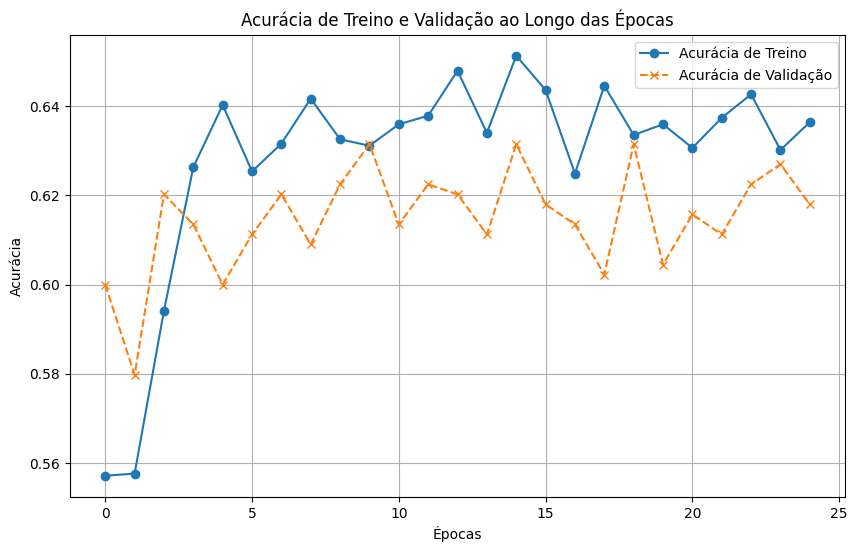

In [25]:
#17 Plotar a acurácia de treino e validação
train_acc_np = np.array([x.cpu().numpy() for x in train_acc])
valid_acc_np = np.array([x.cpu().numpy() for x in valid_acc])

plt.figure(figsize=(10, 6))

# Plotar as acurácias de treino e validação
plt.plot(train_acc_np, label='Acurácia de Treino', linestyle='-', marker='o')
plt.plot(valid_acc_np, label='Acurácia de Validação', linestyle='--', marker='x')

# Configurações do gráfico
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Acurácia de Treino e Validação ao Longo das Épocas')
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()


O gráfico do #17 indica que a acurácia de treino aumenta consistentemente ao longo das épocas, mostrando que o modelo está aprendendo os padrões do conjunto de treino. No entanto, a acurácia de validação apresenta flutuações significativas e não melhora consistentemente, o que pode indicar dificuldade do modelo em generalizar para dados não vistos. Essa diferença sugere a possibilidade de overfitting, onde o modelo aprende excessivamente os detalhes do treino, comprometendo o desempenho em novos dados. Ajustes como regularização adicional, mais dados ou técnicas como early stopping podem ser necessários.

### Avaliação do conjunto de testes

In [26]:
#18 Avaliação no conjunto de teste
y_true = []
y_hat = []

test_size = 0
test_loss = 0.0
test_accuracy = 0.0

# Colocar o modelo em modo de avaliação
model.eval()

with torch.no_grad():
    # Loop pelo DataLoader de teste
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Adaptar o número de canais para o esperado pelo DenseNet121
        if images.shape[1] == 1:  # Verificar se as imagens têm apenas 1 canal
            images = images.repeat(1, 3, 1, 1)  # Replicar o canal único para 3 canais (RGB)

        # Forward
        outputs = model(images)
        loss = loss_fn(outputs, F.one_hot(labels, 2).float())

        # Calcular acurácia
        _, preds = torch.max(outputs, 1)
        test_accuracy += torch.sum(preds == labels.data)

        # Salvar valores verdadeiros e previstos
        y_true.extend(labels.cpu().numpy().tolist())
        y_hat.extend(preds.cpu().numpy().tolist())

        # Somar a perda e o tamanho
        test_loss += loss.item() * images.size(0)
        test_size += images.size(0)

# Calcular estatísticas finais do teste
test_loss = test_loss / test_size
test_accuracy = test_accuracy / test_size

print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")



Test Loss: 0.467, Test Accuracy: 0.633


In [27]:
#19 Avaliar métricas adicionais
import torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC, BinaryF1Score
from collections import Counter

# Instanciar métricas
metrics_acc = BinaryAccuracy().to(device)
metric_auroc = BinaryAUROC().to(device)
metric_f1 = BinaryF1Score().to(device)

# Converter para tensores no dispositivo
target = torch.tensor(y_true).to(device)
preds = torch.tensor(y_hat).to(device)

# Verificar distribuição de classes no conjunto de teste
print("Distribuição no conjunto de teste:", Counter(y_true))

# Calcular métricas
if sum(y_true) > 0:  # Verificar se há exemplos positivos
    acc = metrics_acc(preds, target)
    auroc = metric_auroc(preds, target)
    f1 = metric_f1(preds, target)
else:  # Caso não haja exemplos positivos
    acc = metrics_acc(preds, target)
    auroc = torch.tensor(0.0).to(device)
    f1 = torch.tensor(0.0).to(device)

# Exibir métricas
print(f"Test Accuracy: {acc:.3f}")
print(f"Test AUROC: {auroc:.3f}")
print(f"Test F1: {f1:.3f}")


Distribuição no conjunto de teste: Counter({0: 250, 1: 199})
Test Accuracy: 0.633
Test AUROC: 0.602
Test F1: 0.444


In [28]:
#20 Verificar distribuição das classes no conjunto de teste
print(f"Número de exemplos classe 0 (normal): {len([x for x in y_true if x == 0])}")
print(f"Número de exemplos classe 1 (anormal): {len([x for x in y_true if x == 1])}")

# Contexto adicional (opcional)
total = len(y_true)
print(f"Porcentagem de exemplos classe 0 (normal): {len([x for x in y_true if x == 0]) / total:.2%}")
print(f"Porcentagem de exemplos classe 1 (anormal): {len([x for x in y_true if x == 1]) / total:.2%}")


Número de exemplos classe 0 (normal): 250
Número de exemplos classe 1 (anormal): 199
Porcentagem de exemplos classe 0 (normal): 55.68%
Porcentagem de exemplos classe 1 (anormal): 44.32%
